Particle swarms
============

In this notebook we will examine how to create, setup and use particle swarms. While finite element variables are defined and updated on the mesh particle swarms are free to advect anywhere inside the box. They are generally used to carry material information for use by the system solvers in underworld (see user guide **06_Systems.ipynb**) such as the viscosity and/or density of a slab as it subducts. 


**This notebook is broken down into the following examples:**
1. creating simple global swarms
2. creating a swarm based on coordinate list
3. directly editing swarms
4. setting swarm particle properties based on FE variables
5. creating shapes using swarms

**Keywords:** swarms, particles, shapes


In [1]:
%matplotlib inline
import underworld as uw
import glucifer.pylab as plt

Setting up a global swarm
----------

Set up a random distribution of particles over a given mesh. The density of particles per cell controls the total number of particles.

**Set simulation parameters**

Number of spatial dimensions, box size and the resolution.

In [2]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 4

**Create a mesh**

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))

linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

**Initialise a swarm**

Initialise a swarm on a given mesh, here the ``elementMesh``.

In [4]:
swarm = uw.swarm.Swarm( feMesh=elementMesh )

**Create a layout object**

Create a layout object that will populate the swarm across the whole domain of the mesh. To populate the mesh the density of particles is required, i.e. the number of particles per cell.

In [5]:
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

**Active the layout**

In [6]:
swarm.populate_using_layout( layout=swarmLayout )


**Plot resulting swarm of random particles**

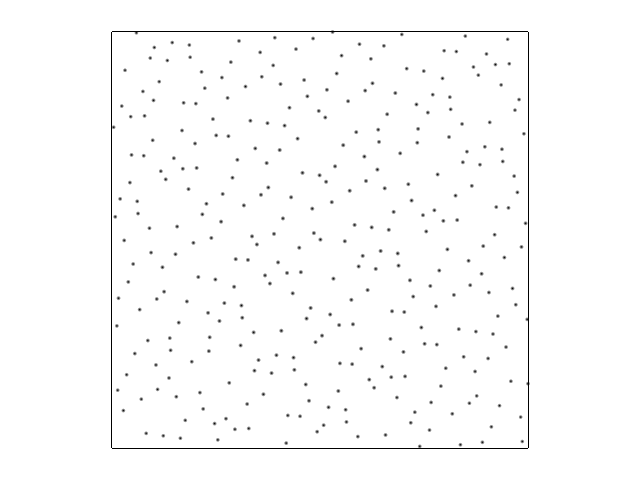

In [7]:
fig1 = plt.Figure()
fig1.Points( swarm=swarm, pointSize=5, colourBar = False )
fig1.show()

**Plot again with the mesh**

This makes it easier to see that there are the right number of particles in each cell.

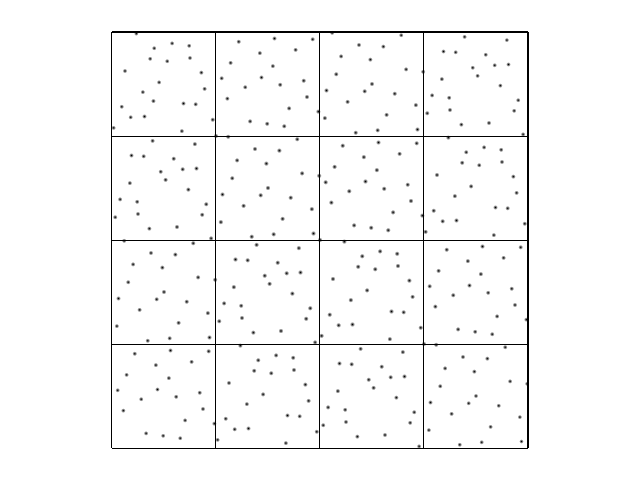

In [8]:
fig2 = plt.Figure()
fig2.Points( swarm=swarm, pointSize=5, colourBar = False )
fig2.Mesh( elementMesh, colourBar = False )
fig2.show()

Creating a swarm from a coordinate list
---------

We can use the swarm particle method, with the above plotting method, to visualise the mesh nodes. To this end a swarm is created and the particle coordinates are set to be the coordinates used for each node point on the mesh.

First lets look at what the data for the first 5 points looks like for the mesh.

In [9]:
print(elementMesh.data[0:5])

[[ 0.    0.  ]
 [ 0.25  0.  ]
 [ 0.5   0.  ]
 [ 0.75  0.  ]
 [ 1.    0.  ]]


Since these 5 entries are the x, z (in 2D) coordinates for each mesh point, then they can be used directly to set the positions for the swarm particles

In [10]:
# setup a new swarm. At this point there is no data in the swarm
swarmForElementMesh = uw.swarm.Swarm( feMesh=elementMesh )
# setup an array containing the position data from the elementMesh data
swarmCoords = elementMesh.data
# use this array to add particles to the newly created swarm
swarmForElementMesh.add_particles_with_coordinates( swarmCoords )

# setup a new swarm
swarmForConstantMesh = uw.swarm.Swarm( feMesh=elementMesh ) # note this must be the whole mesh; elementMesh
# setup an array containing the position data from the constantMesh data
swarmCoords = constantMesh.data
# use this array to add particles to the newly created swarm
swarmForConstantMesh.add_particles_with_coordinates( swarmCoords )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

The final output from this will be a linear array with the same number of entries as there are nodes in the constantMesh (shown above).

**Plot meshes**

Now we can plot these two swarms to see the ElementMesh (mesh points on the edges of the cells) and the ConstantMesh (mesh points inside each cell).

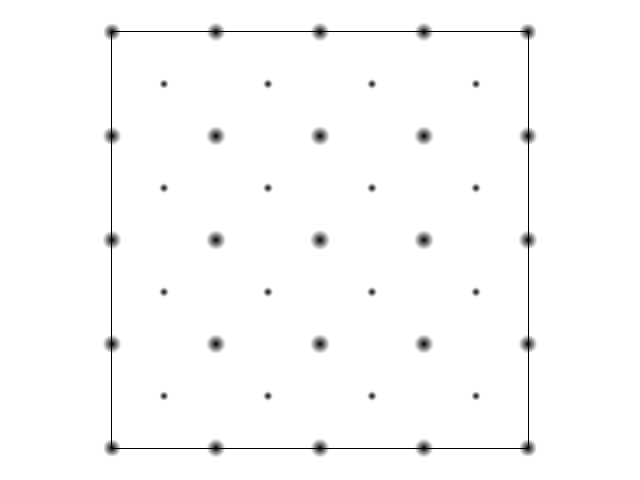

In [11]:
fig3 = plt.Figure()
fig3.Points( swarm=swarmForElementMesh , pointSize=20, colourBar = False)
fig3.Points( swarm=swarmForConstantMesh, pointSize=10, colourBar = False)
fig3.show()

Directly editing swarms
-----

Here we will demonstrate how to edit the coordinates for a single swarm particle.

**Create a new swarm**

Create a new swarm using the mesh as particle coordinates, as above.

In [12]:
# initialise a swarm
swarmCustom = uw.swarm.Swarm( feMesh=elementMesh )
# setup an array containing the position data from the elementMesh data
swarmCoords = elementMesh.data
# use this array to add particles to the newly created swarm
swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int32)

**Look at the swarm data**

Examine the position data stored inside the swarm objects.

In [13]:
print('Head of swarm positions')
print(swarmCustom.particleCoordinates.data[0:5])
print('Tail of swarm positions')
print(swarmCustom.particleCoordinates.data[-5:])
iMid = len(swarmCustom.particleCoordinates.data)/2
print('Mid-way particle = {0:4d}'.format(iMid))
xCoord = swarmCustom.particleCoordinates.data[iMid][0]
yCoord = swarmCustom.particleCoordinates.data[iMid][1]
print('x = {0:.2f}; y = {1:.2f}'.format(xCoord,yCoord))

Head of swarm positions
[[ 0.    0.  ]
 [ 0.25  0.  ]
 [ 0.5   0.  ]
 [ 0.75  0.  ]
 [ 1.    0.  ]]
Tail of swarm positions
[[ 0.    1.  ]
 [ 0.25  1.  ]
 [ 0.5   1.  ]
 [ 0.75  1.  ]
 [ 1.    1.  ]]
Mid-way particle =   12
x = 0.50; y = 0.50


**Plot current positions for swarm particles**


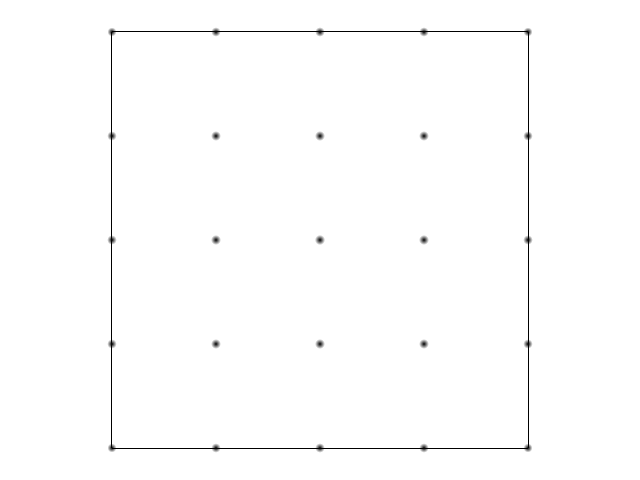

In [14]:
fig4 = plt.Figure()
fig4.Points( swarm=swarmCustom, pointSize=10, colour='blue', colourBar = False)
fig4.show()

**Shift a single particle**

If we want to move a single particle, say the one to the right of the bottom left corner. The particles are numbered from bottom left to top right (increasing with increasing x and z). So the bottom left corner is particle index 0, and the one to the right of this is particle index 1.

In [15]:
swarmCustom.particleCoordinates.data[1][1]=swarmCustom.particleCoordinates.data[1][1]+0.1

**Replot with shifted particle**

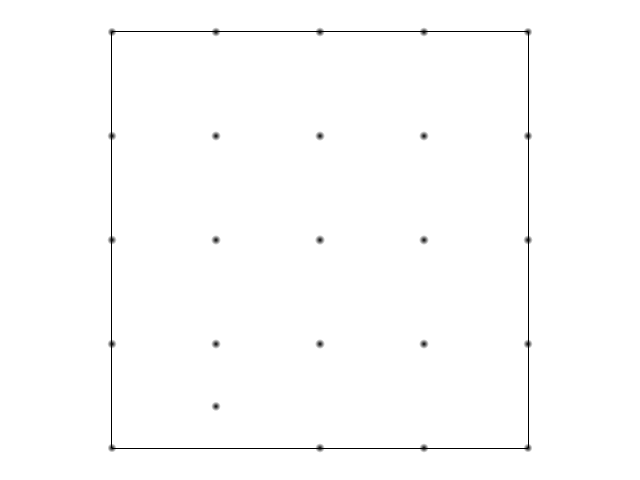

In [16]:
fig5 = plt.Figure()
fig5.Points( swarm=swarmCustom, pointSize=10, colourBar = False)
fig5.show()

**Caution regarding swarm objects**

Making a copy of a swarm and manipulating it will change the original. Also using *copy.copy* in python will not copy the swarm object correctly.

So the following cell will have the effect of undoing the move of particle 1 in the original swarm, even though it looks like we are changing a new swarm.

In [17]:
swarmCustomMod = swarmCustom

swarmCustomMod.particleCoordinates.data[1][1]=swarmCustomMod.particleCoordinates.data[1][1]-0.1

**Replot the original edited swarm**

Note that the particle has moved back to it's position even though ``swarmCustom`` was not modified directly.

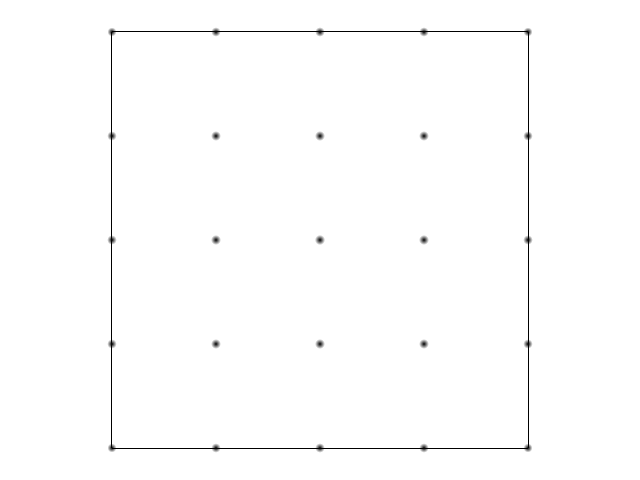

In [18]:
fig6 = plt.Figure()
fig6.Points( swarm=swarmCustom, pointSize=10, colourBar = False)
fig6.show()

Setting swarm properties based on FE variable values
---------

In this example we will create a new variable for the particles and choose it's value based on the temperature at the particle's spatial coordinates. 

**Create new variable for swarm object**

Firstly, create a new variable (an integer in this case) attached to the swarm object made in the previous example.

In [19]:
swarmVariable = swarmCustom.add_variable( dataType="int", count=1 )

**Make a temperature field example**

In [20]:
temperatureMesh = elementMesh
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = (1.0 - coord[1])

Set the newly created variable to integer values based on the temperature at each index. Since the swarm particles directly line up with the mesh for the temperature FE variable then a direct copy is possible.

In [21]:
swarmVariable.data[:] = temperatureField.data[:]*10.
print swarmVariable.data[0:10]

[[10]
 [10]
 [10]
 [10]
 [10]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 7]]


**Plot swarm particles using new variable as the colour**

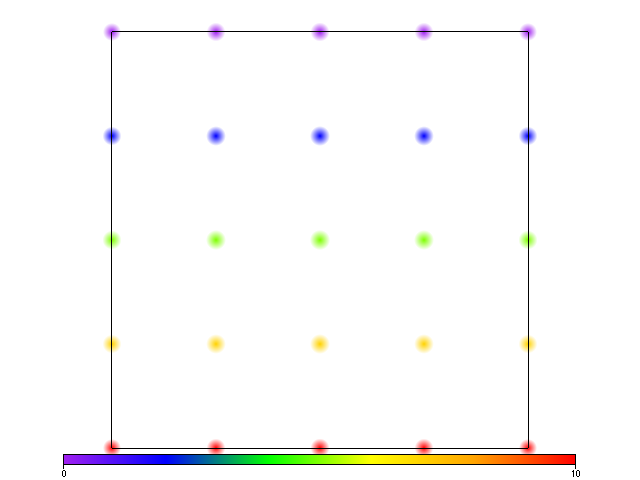

In [22]:
fig7 = plt.Figure()
fig7.Points( swarm=swarmCustom, pointSize=20, colourVariable=swarmVariable, colourBar = True)
fig7.show()

Making shapes
-----

In this example we will make a few different shapes using a single particle swarm, but by changing the ``swarmVariable``. By using an additional variable for each particle any information can be carried by the particles, for example densities and viscosities. These can then be evaluated on the mesh points, allowing interaction between the swarms and the FE variables - i.e. allowing the temperature field to be coupled to viscosity. This coupling will be discussed more in the next notebook, **05_Functions.ipynb**.

For more information on how this method can be used to set material parameters to particles see the tutorial **1_05_StokesSinker.ipynb**.

**Create a higher resolution mesh**

In [23]:
res = 64
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (1., 1.) )

**Create a swarm with random positions on the mesh**

In [24]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( feMesh=elementMesh )
# add a data variable which will store an index to determine material
swarmIndex = swarm.add_variable( dataType="int", count=1 )
# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# activate the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Plot the swarm**

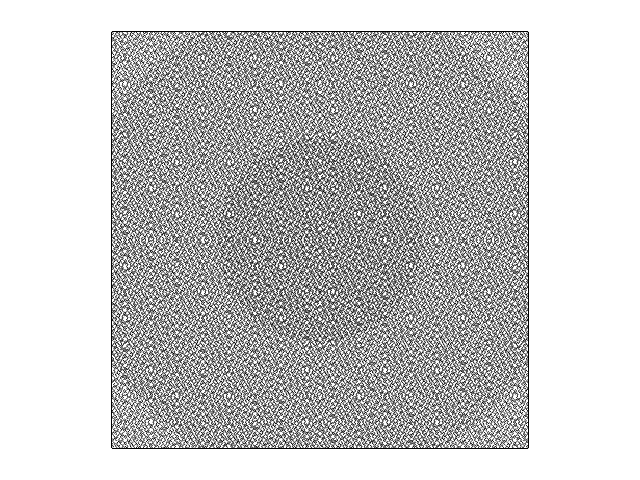

In [25]:
fig8 = plt.Figure()
fig8.Points( swarm=swarm, pointSize=2.0, colourBar = False)
fig8.show()

Loop through a sample of the particles and display their particle identifier, spatial coordinates and index value (yet to be set).

In [26]:
numberParticles = len(swarm.particleCoordinates.data)
print('Total number of swarm partciles = {0:6d}'.format(numberParticles))
for pID in range(numberParticles):
    if(pID < 5):
        print('id = {0:6d}; x = {1:.3f}, y = {2:.3f}, index = {3:1d}'
              .format(pID, swarm.particleCoordinates.data[pID][0], swarm.particleCoordinates.data[pID][1]
                           , int(swarmIndex.data[pID])))
    if(pID > numberParticles-5):
        print('id = {0:6d}; x = {1:.3f}, y = {2:.3f}, index = {3:1d}'
              .format(pID, swarm.particleCoordinates.data[pID][0], swarm.particleCoordinates.data[pID][1]
                           , int(swarmIndex.data[pID])))


Total number of swarm partciles =  81920
id =      0; x = 0.500, y = 0.500, index = 0
id =      1; x = 0.250, y = 0.750, index = 0
id =      2; x = 0.750, y = 0.250, index = 0
id =      3; x = 0.125, y = 0.875, index = 0
id =      4; x = 0.625, y = 0.375, index = 0
id =  81916; x = 0.049, y = 0.874, index = 0
id =  81917; x = 0.799, y = 0.624, index = 0
id =  81918; x = 0.299, y = 0.124, index = 0
id =  81919; x = 0.807, y = 0.620, index = 0


**Define a shape: circle**

Want to have a definition of a circle based on the position of each swarm particle.

There is an easier way to create shapes using functions and conditional statements, but that will be left until user guide **05_Functions.ipynb**.

Here we will use loops to go through each particle in the swarm manually and allocate an index depending on the particle's spatial coordinates.


Firstly, specify parameters for the circle

In [27]:
circleRadius = 0.1
circleCentre = (0.5, 0.5)

Use the location of each particle to set the index depending on if the position is inside the circle.

In [28]:
for pID in range(numberParticles):
    x = swarm.particleCoordinates.data[pID][0]
    z = swarm.particleCoordinates.data[pID][1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        swarmIndex.data[pID] = 1
    else:
        swarmIndex.data[pID] = 0

Plot the modified swarm based on the index number

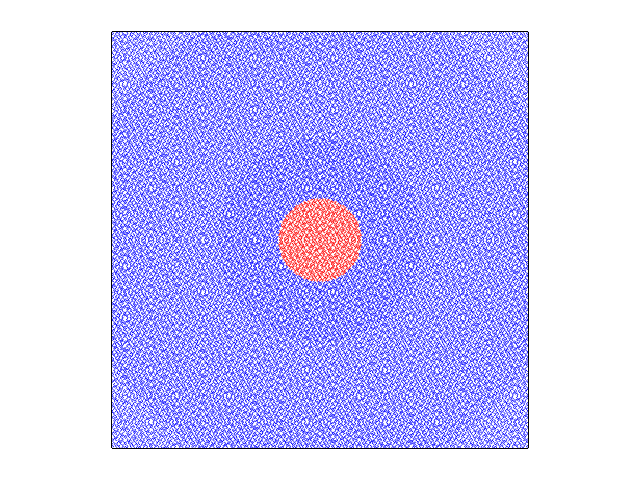

In [29]:
fig9 = plt.Figure()
fig9.Points( swarm=swarm, colourVariable=swarmIndex, colours='blue red', colourBar = False, pointSize=2.0 )
fig9.show()

**Define a shape: Box**

Use the same method as above to define a box and use this to set the particle swarm index.

In [30]:
squareCentre = (0.5, 0.5)
squareWidth  = 0.1

Use the location of each particle to set the index depending on if the position is inside the square.

In [31]:
for pID in range(numberParticles):
    x = swarm.particleCoordinates.data[pID][0]
    z = swarm.particleCoordinates.data[pID][1]
    xx = x - squareCentre[0]
    zz = z - squareCentre[1]
    xCond = (xx*xx) < (squareWidth/2.0)**2
    zCond = (zz*zz) < (squareWidth/2.0)**2
    condition = (xCond & zCond) # use the & operator to return true only if both conditions are satisfied
    if(condition == True):  # inside the square
        swarmIndex.data[pID] = 1
    else:
        swarmIndex.data[pID] = 0

Plot the modified swarm based on the index number

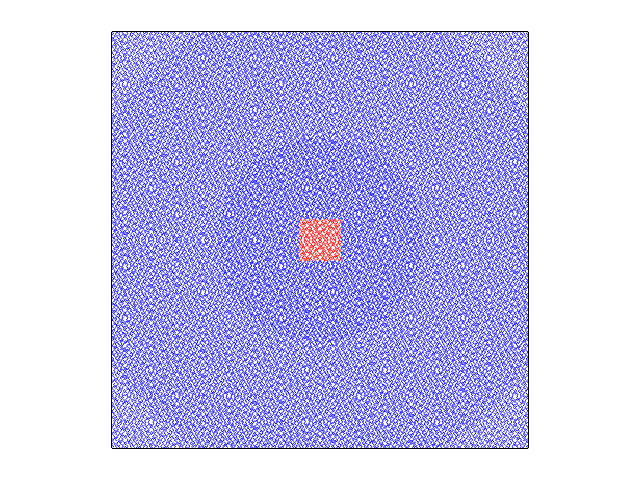

In [32]:
fig10 = plt.Figure()
fig10.Points( swarm=swarm, colourVariable=swarmIndex, colours='blue red', colourBar = False, pointSize=2.0 )
fig10.show()